In [19]:

import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
TRAIN_DIR = "dataset-allin/split/train"
VAL_DIR = "dataset-allin/split/val"
TEST_DIR = "dataset-allin/split/test"

# #1.1 Data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.05),
])

# Normalization layer
normalization_layer = layers.Rescaling(1./255)

#1.2 Load data
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb"
)
val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)
test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)

# 1.3 Apply augmentation and normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

Found 1286 files belonging to 3 classes.
Found 275 files belonging to 3 classes.
Found 278 files belonging to 3 classes.


In [20]:
#2.1 Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),  # Convert to numpy array
    y=np.array([0] * 482 + [1] * 547 + [2] * 257)  # Convert to numpy array
)

class_weights = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class weights: {class_weights}")

#2.2 Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/cnn-transformer/stage1_frozen_backbone1.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

Class weights: {0: np.float64(0.8893499308437067), 1: np.float64(0.7836684948202316), 2: np.float64(1.667963683527886)}


In [21]:
# #3.1 Build ResNet-ViT Hybrid Model
# num_classes = 3

# def simple_true_hybrid(num_classes, input_shape=(224, 224, 3)):
#     inputs = keras.Input(shape=input_shape)

#     # ResNet backbone
#     base_model = keras.applications.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_tensor=inputs,
#     )

#     # Freeze early layers
#     for layer in base_model.layers[:100]:
#         layer.trainable = False

#     # Get features and convert to patches
#     features = base_model.output  # 7x7x2048
#     x = layers.Conv2D(512, kernel_size=1, activation='relu')(features)  # 7x7x512
#     x = layers.Reshape((49, 512))(x)  # 49 patches

#     # Minimal transformer (single attention head)
#     x = layers.MultiHeadAttention(num_heads=1, key_dim=512)(x, x)
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dropout(0.5)(x)

#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     return keras.Model(inputs=inputs, outputs=outputs)

# # Compile with slightly higher LR
# model = simple_true_hybrid(num_classes=num_classes)
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=3e-5),  # Increased from 1e-5
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )


# # Build and compile
# model = simple_true_hybrid(num_classes=num_classes)
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [22]:
# 4. Define the ResNet50 + Transformer hybrid model and keep a reference to the backbone

def cnn_transformer(num_classes=3, input_shape=(224, 224, 3)):
    inputs = keras.Input(shape=input_shape)

    # CNN backbone (pretrained, partial freeze)
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None,
        name="resnet50_backbone"
    )
    base_model.trainable = False  # Freeze all layers initially

    # Patch embedding: convert feature map to patches
    x = base_model.output  # (7, 7, 2048)
    x = layers.Conv2D(256, kernel_size=1, activation='relu')(x)  # (7, 7, 256)
    x = layers.Reshape((49, 256))(x)  # (batch, 49, 256)

    # Add class token (ViT-style) using Lambda for symbolic batch size
    class_token = tf.Variable(tf.zeros((1, 1, 256)), trainable=True, name="class_token")
    def add_class_token(inputs):
        batch_size = tf.shape(inputs)[0]
        tokens = tf.tile(class_token, [batch_size, 1, 1])
        return tf.concat([tokens, inputs], axis=1)
    x = layers.Lambda(add_class_token)(x)  # (batch, 50, 256)

    # Positional encoding
    pos_embed = layers.Embedding(input_dim=50, output_dim=256)(tf.range(50))
    x = x + pos_embed

    # Stack 2 transformer blocks
    for _ in range(2):
        attn = layers.MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.2)(x, x)
        x = layers.LayerNormalization()(x + attn)
        mlp = layers.Dense(512, activation='gelu')(x)
        mlp = layers.Dropout(0.2)(mlp)
        mlp = layers.Dense(256)(mlp)
        x = layers.LayerNormalization()(x + mlp)

    # Use class token for classification
    x = layers.Lambda(lambda v: v[:, 0])(x)  # (batch, 256)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    # Attach the backbone as an attribute for easy access later
    model.resnet_base = base_model
    return model

# Build and compile
model = cnn_transformer()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Train the model
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Save the weights
model.save_weights('checkpoints/cnn-transformer2/model_weights.weights.h5')
print("Saved model weights.")

model.save('checkpoints/cnn-transformer2/model.keras')
print("Saved complete model.")

Epoch 1/20
28/81 ━━━━━━━━━━━━━━━━━━━━ 32s 615ms/step - accuracy: 0.3543 - loss: 1.9882

KeyboardInterrupt: 

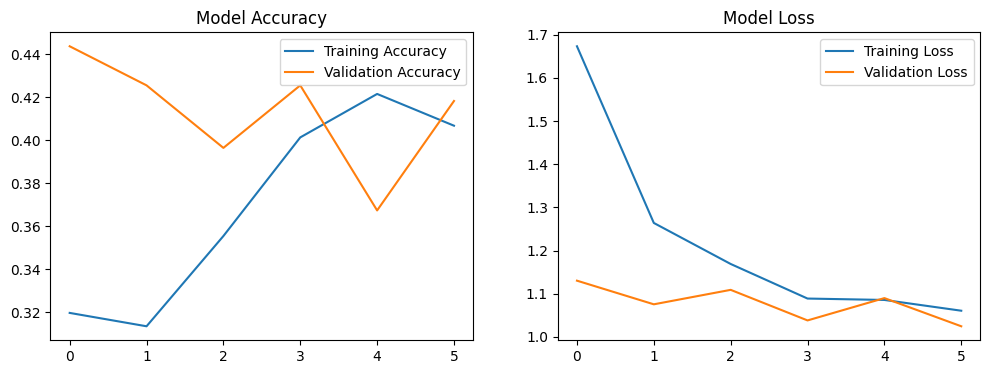

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
# STAGE 1: Unfreeze just the last 10 layers of the backbone
print("Stage 1: Unfreezing last 10 layers of backbone...")
for layer in model.resnet_base.layers[:-10]:
    layer.trainable = False
for layer in model.resnet_base.layers[-10:]:
    layer.trainable = True

# Use a very low learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Create stage 1 callbacks with a specific checkpoint
stage1_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        mode='max',
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/cnn-transformer2/stage1_finetuned.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# Fine-tune with last 10 layers unfrozen
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=stage1_callbacks
)

# Evaluate stage 1
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Stage 1 fine-tuned accuracy: {test_acc:.4f}")
print(f"Stage 1 fine-tuned loss: {test_loss:.4f}")

# STAGE 2: Unfreeze more layers (last 30)
print("\nStage 2: Unfreezing last 30 layers of backbone...")
for layer in model.resnet_base.layers[:-30]:
    layer.trainable = False
for layer in model.resnet_base.layers[-30:]:
    layer.trainable = True

# Use an even lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Create stage 2 callbacks
stage2_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        mode='max',
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/cnn-transformer2/stage2_finetuned.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# Fine-tune with more layers unfrozen
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=stage2_callbacks
)

# Evaluate final model
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Final fine-tuned accuracy: {test_acc:.4f}")
print(f"Final fine-tuned loss: {test_loss:.4f}")

# Save the final fine-tuned weights
model.save_weights('checkpoints/cnn-transformer2/model_weights_final.weights.h5')
print("Saved final fine-tuned weights.")

Stage 1: Unfreezing last 10 layers of backbone...
Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 742ms/step - accuracy: 0.2939 - loss: 1.3393 - val_accuracy: 0.2000 - val_loss: 1.1107 - learning_rate: 5.0000e-06
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 716ms/step - accuracy: 0.3367 - loss: 1.2791 - val_accuracy: 0.2000 - val_loss: 1.1046 - learning_rate: 5.0000e-06
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 61s 759ms/step - accuracy: 0.3686 - loss: 1.2493 - val_accuracy: 0.2000 - val_loss: 1.1026 - learning_rate: 5.0000e-06
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 711ms/step - accuracy: 0.3523 - loss: 1.2674 - val_accuracy: 0.3055 - val_loss: 1.0967 - learning_rate: 5.0000e-06
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 740ms/step - accuracy: 0.3414 - loss: 1.2328 - val_accuracy: 0.3564 - val_loss: 1.0801 - learning_rate: 5.0000e-06
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 721ms/step - accuracy: 0.3631 - loss: 1.2428 - val_accuracy: 0.4109 - val_loss: 1.0720 - learning_rate: 5.0000e-06
Epoch 7/

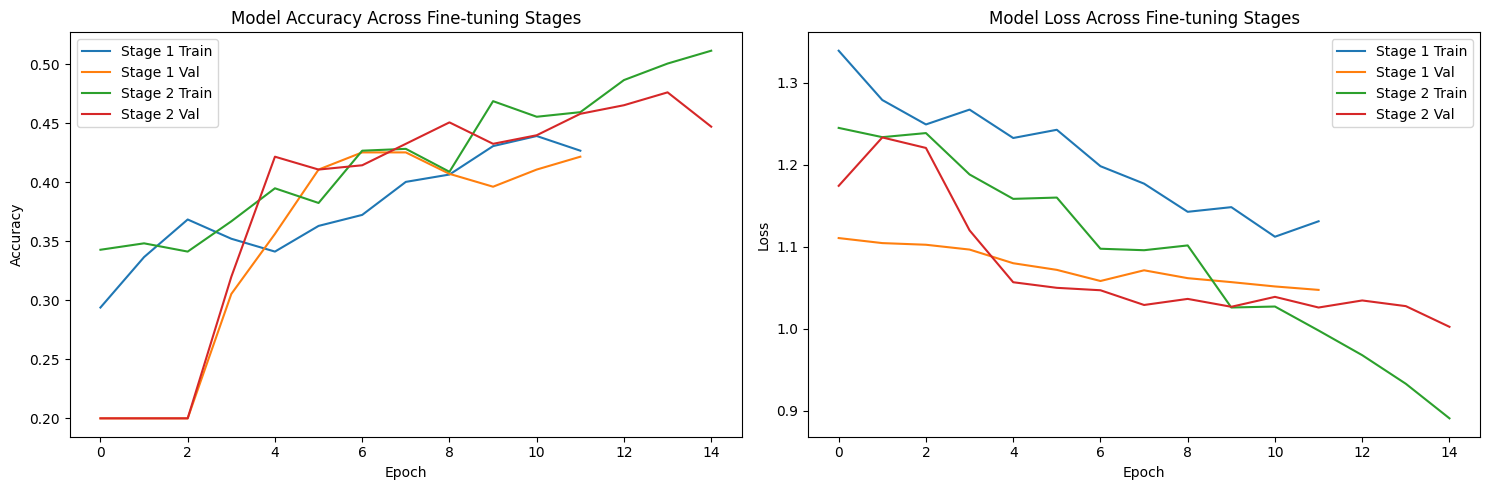

In [ ]:
# Plot Stage 1 & 2 learning curves
plt.figure(figsize=(15, 5))

# Stage 1 plots
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Stage 1 Train')
plt.plot(history_stage1.history['val_accuracy'], label='Stage 1 Val')
plt.plot(history_stage2.history['accuracy'], label='Stage 2 Train')
plt.plot(history_stage2.history['val_accuracy'], label='Stage 2 Val')
plt.title('Model Accuracy Across Fine-tuning Stages')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Stage 1 Train')
plt.plot(history_stage1.history['val_loss'], label='Stage 1 Val')
plt.plot(history_stage2.history['loss'], label='Stage 2 Train')
plt.plot(history_stage2.history['val_loss'], label='Stage 2 Val')
plt.title('Model Loss Across Fine-tuning Stages')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

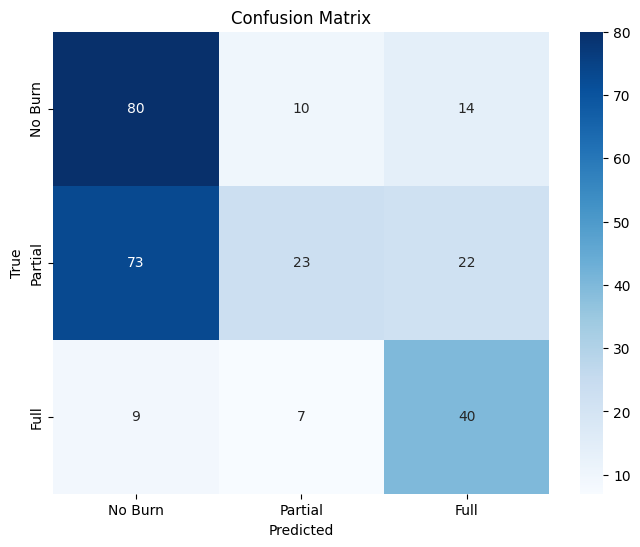

              precision    recall  f1-score   support

     No Burn       0.49      0.77      0.60       104
     Partial       0.57      0.19      0.29       118
        Full       0.53      0.71      0.61        56

    accuracy                           0.51       278
   macro avg       0.53      0.56      0.50       278
weighted avg       0.53      0.51      0.47       278



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Burn', 'Partial', 'Full'],
            yticklabels=['No Burn', 'Partial', 'Full'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred,
                           target_names=['No Burn', 'Partial', 'Full']))

In [ ]:
# Load the best weights (Stage 2)
model.load_weights('checkpoints/cnn-transformer2/stage2_finetuned.weights.h5')

# Verify we have the best performance back
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Restored accuracy: {test_acc:.4f}")

c:\Users\ksan\Documents\thesis\automated-thermal-burn-severity-classifyer\.venv-training\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 194 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step - accuracy: 0.5144 - loss: 0.9716
Restored accuracy: 0.5144


In [ ]:
# Try Stage 3 with fewer layers (last 40 instead of 50)
print("\nModified Stage 3: Unfreezing last 40 layers with higher learning rate...")
for layer in model.resnet_base.layers[:-40]:
    layer.trainable = False
for layer in model.resnet_base.layers[-40:]:
    layer.trainable = True

# Use a slightly higher learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=8e-7),  # Slightly higher
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with the same callbacks
history_stage3_modified = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)


Modified Stage 3: Unfreezing last 40 layers with higher learning rate...
Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 91s 969ms/step - accuracy: 0.4012 - loss: 1.1553 - val_accuracy: 0.4073 - val_loss: 1.0824 - learning_rate: 8.0000e-07
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 76s 935ms/step - accuracy: 0.4012 - loss: 1.1569 - val_accuracy: 0.2982 - val_loss: 1.1199 - learning_rate: 8.0000e-07
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 951ms/step - accuracy: 0.4090 - loss: 1.1243 - val_accuracy: 0.4218 - val_loss: 1.0927 - learning_rate: 8.0000e-07
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 947ms/step - accuracy: 0.4215 - loss: 1.0871 - val_accuracy: 0.4182 - val_loss: 1.0655 - learning_rate: 4.0000e-07
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 953ms/step - accuracy: 0.4370 - loss: 1.0597 - val_accuracy: 0.3927 - val_loss: 1.0404 - learning_rate: 4.0000e-07


In [24]:
# First rebuild the model to ensure correct architecture
model = cnn_transformer()
model.load_weights('checkpoints/cnn-transformer2/stage2_finetuned.weights.h5')

# Get the backbone output layer by its actual name
base_features = model.get_layer('conv5_block3_out').output

# Create a better transformer head
x = layers.Conv2D(384, kernel_size=1, activation='relu')(base_features)
x = layers.Reshape((49, 384))(x)

# Create a new class token
class_token = tf.Variable(tf.random.normal((1, 1, 384)) * 0.02)
def add_class_token(inputs):
    batch_size = tf.shape(inputs)[0]
    tokens = tf.tile(class_token, [batch_size, 1, 1])
    return tf.concat([tokens, inputs], axis=1)

x = layers.Lambda(add_class_token)(x)
pos_embed = layers.Embedding(input_dim=50, output_dim=384)(tf.range(50))
x = x + pos_embed

# 4 transformer blocks instead of 2
for _ in range(4):
    attn = layers.MultiHeadAttention(num_heads=8, key_dim=48)(x, x)
    x = layers.LayerNormalization()(x + attn)
    mlp = layers.Dense(768, activation='gelu')(x)
    mlp = layers.Dropout(0.1)(mlp)
    mlp = layers.Dense(384)(mlp)
    x = layers.LayerNormalization()(x + mlp)

x = layers.Lambda(lambda v: v[:, 0])(x)
x = layers.Dense(3, activation='softmax')(x)

# Create new model
enhanced_model = keras.Model(model.inputs, x)

# Set trainable layers (access via model.layers)
resnet_layers = [layer for layer in model.layers if 'conv' in layer.name]
for layer in resnet_layers[:-30]:
    layer.trainable = False

# Compile
enhanced_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
enhanced_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 29,111,171 (111.05 MB)

 Trainable params: 5,523,459 (21.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Create specific callbacks for enhanced model
enhanced_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,  # More patience for the enhanced model
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=4,
        mode='max',
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/cnn-transformer2/enhanced_model.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# Train the enhanced model
print("Training enhanced model...")
history_enhanced = enhanced_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Train longer
    class_weight=class_weights,
    callbacks=enhanced_callbacks
)

# Evaluate
test_loss, test_acc = enhanced_model.evaluate(test_ds, verbose=1)
print(f"Enhanced model accuracy: {test_acc:.4f}")
print(f"Enhanced model loss: {test_loss:.4f}")

Training enhanced model...
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 814ms/step - accuracy: 0.4160 - loss: 1.0884 - val_accuracy: 0.5164 - val_loss: 0.9164 - learning_rate: 3.0000e-05
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 776ms/step - accuracy: 0.4876 - loss: 0.9529 - val_accuracy: 0.4691 - val_loss: 0.9478 - learning_rate: 3.0000e-05
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - accuracy: 0.5148 - loss: 0.9121 - val_accuracy: 0.4909 - val_loss: 0.9214 - learning_rate: 3.0000e-05
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - accuracy: 0.5101 - loss: 0.9014 - val_accuracy: 0.4982 - val_loss: 0.9048 - learning_rate: 3.0000e-05
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 64s 787ms/step - accuracy: 0.5311 - loss: 0.8559 - val_accuracy: 0.4909 - val_loss: 0.9124 - learning_rate: 3.0000e-05
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 781ms/step - accuracy: 0.5762 - loss: 0.7979 - val_accuracy: 0.5091 - val_loss: 0.9029 - learning_rate: 6.0000e-06
Epoch 7/30
81/81 ━━━━━━━━━━━━━━

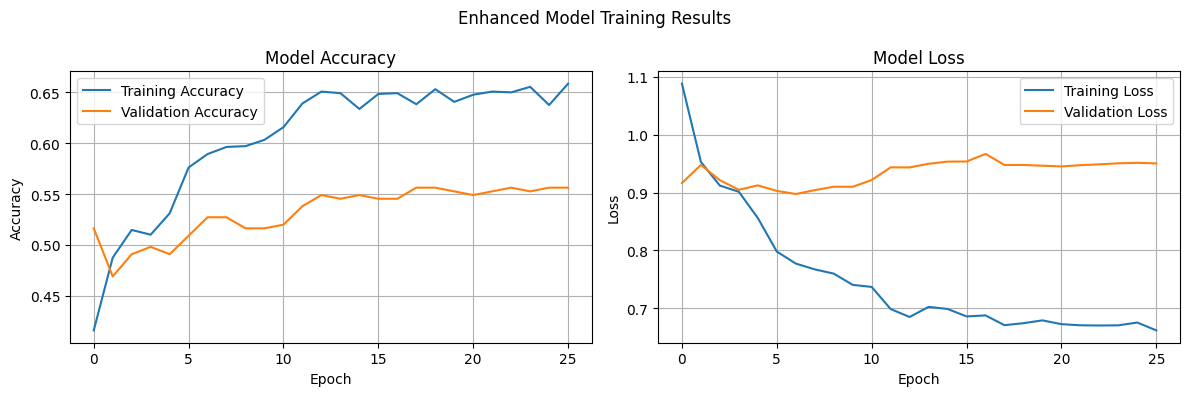

In [27]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot your results
plot_training_history(history_enhanced, "Enhanced Model Training Results")

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 660ms/step


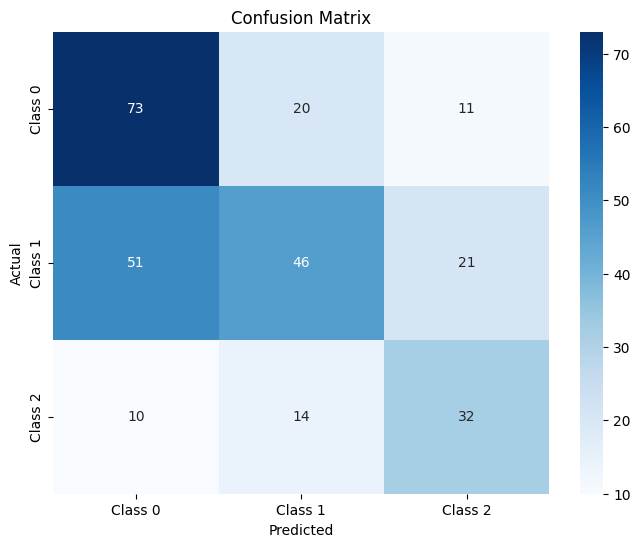


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.54      0.70      0.61       104
     Class 1       0.57      0.39      0.46       118
     Class 2       0.50      0.57      0.53        56

    accuracy                           0.54       278
   macro avg       0.54      0.55      0.54       278
weighted avg       0.55      0.54      0.53       278


Confusion Matrix:
Predicted ->
Actual ↓
[[73 20 11]
 [51 46 21]
 [10 14 32]]
Class 0 accuracy: 0.7019
Class 1 accuracy: 0.3898
Class 2 accuracy: 0.5714


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on test set
y_pred_probs = enhanced_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for batch in test_ds:
    y_true.extend(batch[1].numpy())
y_true = np.array(y_true)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred,
                          target_names=['Class 0', 'Class 1', 'Class 2']))

# Print confusion matrix with percentages
print("\nConfusion Matrix:")
print("Predicted ->")
print("Actual ↓")
print(cm)

# Calculate per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} accuracy: {acc:.4f}")

In [29]:
enhanced_model.save_weights('checkpoints/cnn-transformer2/enhanced_final_weights.weights.h5')
print("Weights saved!")

Weights saved!
